<a href="https://colab.research.google.com/github/hendrikyong/CVNL_Assignment_1/blob/main/CVNL_Assg1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sonos/nlu-benchmark.git
!ls nlu-benchmark/2017-06-custom-intent-engines/AddToPlaylist


Cloning into 'nlu-benchmark'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 400 (delta 2), reused 11 (delta 2), pack-reused 389 (from 1)
Receiving objects: 100% (400/400), 1.19 MiB | 9.47 MiB/s, done.
Resolving deltas: 100% (248/248), done.
Alexa_metrics.json   Snips_metrics_full.json	    train_AddToPlaylist.json
api.ai_metrics.json  Snips_metrics.json		    validate_AddToPlaylist.json
Luis_metrics.json    train_AddToPlaylist_full.json  Wit_metrics.json


In [26]:
import os
import json
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.model_selection import train_test_split

In [5]:
!pip install torch torchvision
!pip install torchtext

In [31]:
def load_data(base_dir):
    intents = []
    texts = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".json"):
                intent = os.path.basename(root)
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        for entry in data:
                            if isinstance(entry, dict) and 'data' in entry:
                                sentence = ''.join([fragment.get('text', '') for fragment in entry['data']])
                                texts.append(sentence)
                                intents.append(intent)
                            elif isinstance(entry, str):
                                texts.append(entry)
                                intents.append(intent)
                except (UnicodeDecodeError, json.JSONDecodeError):
                    print(f"Error reading/parsing {file_path}. Skipping this file.")
    return texts, intents

# Build vocabulary
def build_vocab(texts, min_freq=1):
    counter = Counter(token for text in texts for token in text.split())
    vocab = {word: idx + 2 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

# Load data
data_dir = "nlu-benchmark/2017-06-custom-intent-engines"
texts, intents = load_data(data_dir)

# Build vocabulary and label mappings
vocab = build_vocab(texts)
labels = list(set(intents))
label_to_idx = {label: idx for idx, label in enumerate(labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, intents, test_size=0.2, random_state=42)


Error reading/parsing nlu-benchmark/2017-06-custom-intent-engines/PlayMusic/train_PlayMusic_full.json. Skipping this file.


In [32]:
class IntentDataset(Dataset):
    def __init__(self, texts, labels, vocab, label_to_idx):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = [self.vocab.get(token, self.vocab["<UNK>"]) for token in text.split()]
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(self.label_to_idx[label], dtype=torch.long)

# Collate function to pad sequences
def pad_batch(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<PAD>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts, labels

# Create datasets and dataloaders
train_dataset = IntentDataset(train_texts, train_labels, vocab, label_to_idx)
val_dataset = IntentDataset(val_texts, val_labels, vocab, label_to_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_batch)


In [34]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.rnn(x)
        out = self.fc(hidden[-1])
        return out


# Initialize model
model = RNNClassifier(len(vocab), embed_size=100, hidden_size=256, output_size=len(labels), num_layers=2)


In [35]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_with_tracking(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        accuracy = correct / total

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_loss_history, val_loss_history, val_accuracy_history



Epoch 1/10, Train Loss: 1.9519, Validation Loss: 1.9527, Accuracy: 0.1111
Epoch 2/10, Train Loss: 1.9431, Validation Loss: 1.9605, Accuracy: 0.1429
Epoch 3/10, Train Loss: 1.9379, Validation Loss: 1.9717, Accuracy: 0.0794
Epoch 4/10, Train Loss: 1.9298, Validation Loss: 1.9857, Accuracy: 0.0635
Epoch 5/10, Train Loss: 1.9209, Validation Loss: 2.0080, Accuracy: 0.0635
Epoch 6/10, Train Loss: 1.9059, Validation Loss: 2.0253, Accuracy: 0.0635
Epoch 7/10, Train Loss: 1.8910, Validation Loss: 2.0457, Accuracy: 0.0635
Epoch 8/10, Train Loss: 1.8755, Validation Loss: 2.0388, Accuracy: 0.0635
Epoch 9/10, Train Loss: 1.8609, Validation Loss: 2.0351, Accuracy: 0.0635
Epoch 10/10, Train Loss: 1.8468, Validation Loss: 2.0135, Accuracy: 0.0635


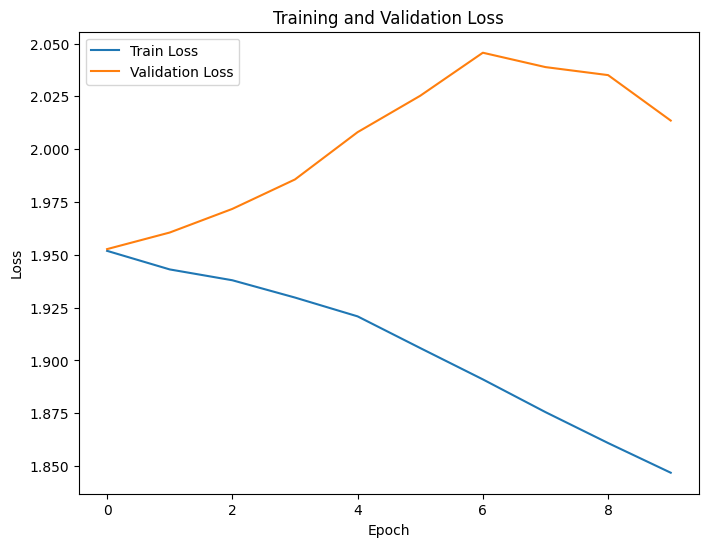

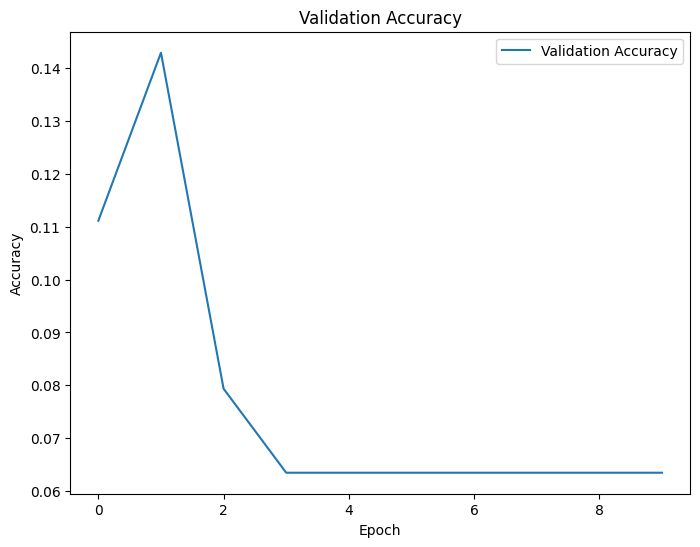

In [36]:
import matplotlib.pyplot as plt

train_loss, val_loss, val_accuracy = train_model_with_tracking(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()
